In [13]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 500e-3
fsm_pupil_diam = 12e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)


10.880468529534333 arcsec
0.13080568720379146


In [3]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [10]:
time.sleep(2)
fsm.write(np.array([[80,50,50]]).T)

In [4]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [4]:
cam.set_roi(475, 850, 200, client0)

In [5]:
cam.set_exptime(0.0001, client0)

In [66]:
cam.Nframes = 1000
df = cam.snap()

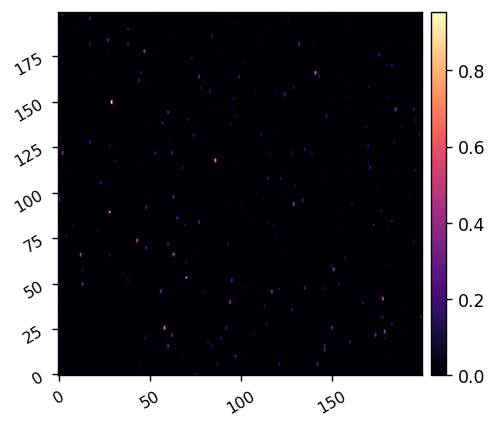

In [144]:
imshow1(df)

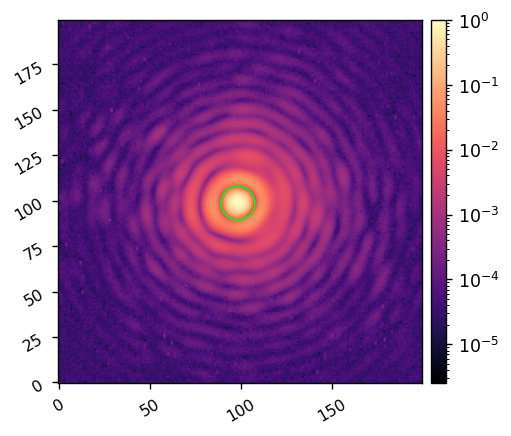

In [17]:
fsm.write(v_bias)

cam.Nframes = 1000
im_bias = cam.snap()

cen = utils.centroid(im_bias)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


Displacements: A = 5.73e-06 m, 4.63e-06 m, 4.63e-06 m. 
Delta Voltages: A = 57.31, B = 46.35, C = 46.35. 
[  0.025 -12.001]


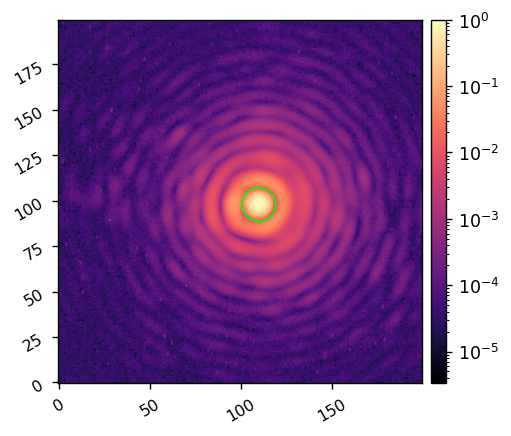

In [20]:
reload(fsm_utils)
v_fsm = fsm_utils.get_fsm_volts(tip=2*as_per_lamD, tilt=0*as_per_lamD)
fsm.write(v_fsm)

im = cam.snap()
shift, _, _ = phase_cross_correlation(im_bias, im, upsample_factor=1000)
print(shift)
cen = utils.centroid(im)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [10]:
np.sqrt(np.sum(np.square(shift))) * pxscl_lamD

np.float64(1.4604878199499294)

In [22]:
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=2*as_per_lamD)
volts = [v_bias, v_tt]
freq = 2
try:
    print('Modulating FSM ...')
    i = 0
    while True:
        fsm.write(volts[i%2])
        i += 1 
        time.sleep(1/freq)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)


Displacements: A = 5.00e-06 m, 5.63e-06 m, 4.37e-06 m. 
Delta Voltages: A = 50.00, B = 56.33, C = 43.67. 
Modulating FSM ...
FSM modulation stopped!
